# レースデータの分析

### 1. 必要なパッケージのインポート

In [14]:
%matplotlib inline
import pandas as pd
import pandas_profiling as pdp

### データ分析

In [3]:
# csvファイルの読み込み
df = pd.read_csv('race_data.csv')

##### column名が日本語のせいで文字化けするので英語化する

In [3]:
# 列名の確認
df.columns

Index(['着順', '枠番', '馬番', '馬名', '性齢', '斤量', '騎手', 'タイム', '着差', '単勝', '人気',
       '馬体重', '調教師', 'race_id', 'horse_id', 'jockey_id', 'trainer_id',
       'race_grade', 'race_type', 'wise', 'meter', 'weather', 'race_state',
       'start_time'],
      dtype='object')

In [4]:
df = df.rename(columns={'着順':'ranking', '枠番':'flame', '馬番':'starters_num',\
            '性齢':'sex_old', '斤量':'weight', '騎手':'jockey', 'タイム':'time',\
            '着差':'arrival_diff', '単勝':'odds', '人気':'popularity','馬体重':'horse_weight', '調教師':'trainer'})

In [5]:
df.columns

Index(['ranking', 'flame', 'starters_num', '馬名', 'sex_old', 'weight', 'jockey',
       'time', 'arrival_diff', 'odds', 'popularity', 'horse_weight', 'trainer',
       'race_id', 'horse_id', 'jockey_id', 'trainer_id', 'race_grade',
       'race_type', 'wise', 'meter', 'weather', 'race_state', 'start_time'],
      dtype='object')

### NAN値の対策

In [6]:
# nan値のあるcolumnの確認
df.isnull().any()

ranking         False
flame           False
starters_num    False
馬名              False
sex_old         False
weight          False
jockey          False
time             True
arrival_diff     True
odds            False
popularity       True
horse_weight    False
trainer         False
race_id         False
horse_id        False
jockey_id       False
trainer_id      False
race_grade      False
race_type       False
wise            False
meter           False
weather         False
race_state      False
start_time      False
dtype: bool

In [5]:
# 欠損データの確認
df[df['popularity'].isnull()].head(3)

,ranking,flame,starters_num,馬名,sex_old,weight,jockey,time,arrival_diff,odds,...,horse_id,jockey_id,trainer_id,race_grade,race_type,wise,meter,weather,race_state,start_time
31,取,6,12,トキノユウ,牡3,56.0,小林淳一,NaN,NaN,---,...,2009104485,712,1007,other,ダート,右,1800,晴,良,10:20
470,除,4,5,エイコオレジェンド,牡5,57.0,宮崎北斗,NaN,NaN,---,...,2007103789,1118,1007,other,ダート,右,2400,晴,良,13:10
573,除,1,1,タニノチャーチル,牡3,56.0,岩田康誠,NaN,NaN,---,...,2009103462,5203,1107,other,ダート,右,1200,晴,良,10:35


##### 出走しなかったレース情報を削除する

In [6]:
df = df[df['ranking'].str.match(r'[0-9]+', na=False)]

In [9]:
# 結果の確認
df.isnull().any()

ranking         False
flame           False
starters_num    False
馬名              False
sex_old         False
weight          False
jockey          False
time            False
arrival_diff     True
odds            False
popularity      False
horse_weight    False
trainer         False
race_id         False
horse_id        False
jockey_id       False
trainer_id      False
race_grade      False
race_type       False
wise            False
meter           False
weather         False
race_state      False
start_time      False
dtype: bool

### 順位と馬番の分布を確認

In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [11]:
visu_df = df.loc[:, ['ranking', 'starters_num', 'race_grade']]
visu_df = visu_df[(visu_df['ranking'] == '1') & (visu_df['race_grade'] == 'G2')]

array([[<AxesSubplot:title={'center':'starters_num'}>]], dtype=object)

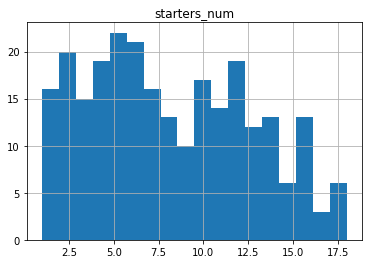

In [27]:
visu_df.hist(bins=18)

TypeError: bar() missing 1 required positional argument: 'height'

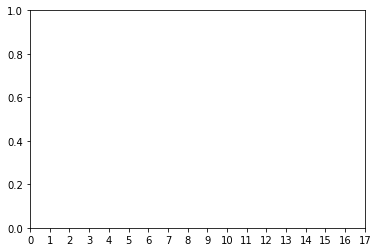

In [22]:
plt.xticks(np.arange(0, 18, 1))
plt.bar(visu_df['starters_num'], range=(1,19), bins=18)

### 新たな列を作成する

In [10]:
# 必要なパッケージのインポート
import re

##### 性齢を性別と年齢に分割する

In [11]:
def split_sex_old(df):
    sexs = []
    olds = []
    for row in df['sex_old']:
        sexs.append(re.sub(r'[0-9]+', '', row))
        olds.append(re.search(r'[0-9]+', row).group())

    df['sex'] = sexs
    df['old'] = olds

    return df

In [12]:
df = split_sex_old(df)

##### 馬体重を体重値と変化量に分ける

In [13]:
# 中身の確認
df[~(df['horse_weight'].str.contains(r'[0-9]+'))]
# 計量不可はなさそう?

,ranking,flame,starters_num,馬名,sex_old,weight,jockey,time,arrival_diff,odds,...,trainer_id,race_grade,race_type,wise,meter,weather,race_state,start_time,sex,old
72005,8,1,2,サビーナクレスタ,牡2,54.0,北村宏司,1:24.5,3/4,25.9,...,1102,other,芝,左,1400,晴,良,12:35,牡,2


In [14]:
def split_horse_weight(df):
    horse_weights = []
    delta_weights = []
    for row in df['horse_weight']:
        delta_weights.append(int(re.search(r'(?<=\().+?(?=\))', row).group()))
        horse_weights.append(int(re.sub(r'\(.+\)', '', row)))

    df['horse_weight'] = horse_weights
    df['delta_weight'] = delta_weights

    return df
        

In [15]:
df.head(5)

,ranking,flame,starters_num,馬名,sex_old,weight,jockey,time,arrival_diff,odds,...,trainer_id,race_grade,race_type,wise,meter,weather,race_state,start_time,sex,old
0,1,8,15,ナムラケイオス,牝3,54.0,蛯名正義,1:13.0,NaN,4.5,...,1116,other,ダート,右,1200,晴,良,09:50,牝,3
1,2,5,9,ジャーフライト,牝3,54.0,三浦皇成,1:13.1,1/2,9.0,...,428,other,ダート,右,1200,晴,良,09:50,牝,3
2,3,7,13,ミルテ,牝3,54.0,江田照男,1:13.7,3.1/2,87.8,...,415,other,ダート,右,1200,晴,良,09:50,牝,3
3,4,4,8,ツインクルスター,牝3,54.0,後藤浩輝,1:13.9,1.1/2,2.5,...,1106,other,ダート,右,1200,晴,良,09:50,牝,3
4,5,7,14,コスモレイラ,牝3,54.0,丹内祐次,1:14.1,1,31.0,...,1035,other,ダート,右,1200,晴,良,09:50,牝,3


### jockeyの情報を組み込むためにデータを確認

In [29]:
# 重賞の出場回数が多い上位15人までを情報として組み込む
# 横山武の情報も入れたいが、出場回数の少なさのため妥協
df[df['race_grade'] != 'other'].loc[:, 'jockey'].value_counts()[:20]

武豊      627
福永祐一    615
岩田康誠    612
川田将雅    595
戸崎圭太    535
ルメール    519
横山典弘    513
田辺裕信    510
池添謙一    508
和田竜二    502
Ｍ．デム    490
内田博幸    485
浜中俊     452
松山弘平    428
三浦皇成    419
幸英明     415
蛯名正義    401
石橋脩     389
北村宏司    363
大野拓弥    351
Name: jockey, dtype: int64

In [30]:
# listにできるか確認
list(df[df['race_grade'] != 'other'].loc[:, 'jockey_id'].value_counts().index[:20])

[666,
 1014,
 5203,
 1088,
 5386,
 5339,
 660,
 1075,
 1032,
 1018,
 5212,
 422,
 1115,
 1126,
 1122,
 732,
 663,
 1077,
 1043,
 1096]

In [ ]:
def jockey_freq(df,top_num=20):
    """jockey_idを重賞の出場頻度上位n人のみに変換する関数

    Parameters
    ----------
    df : pandas.df
        レース情報のデータフレーム
    top_num : int
        出場頻度上位何人までにするか
    """
    freq_list = list(df[df['race_grade'] != 'other'].loc[:, 'jockey_id'].value_counts().index[:20])

    jockey_freqs = []
    for row in df['jockey_id']:
        if row in freq_list:
            jockey_freqs.append(int(row))
        else:
            jockey_freqs.append(-1)

    df['jockey_freq'] = jockey_freqs

    return df
    

In [17]:
# pandas profilingを使ったデータの全体像を表示
# pdp.ProfileReport(df)